In [2]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import progressbar
import catboost
from catboost import CatBoostClassifier
from catboost import Pool
from sklearn.preprocessing import LabelEncoder
from catboost import MetricVisualizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, f1_score
from sklearn.model_selection import train_test_split

import shap
shap.initjs()
import timeit

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, f1_score
from xgboost.sklearn import XGBRegressor, XGBClassifier
from imblearn.over_sampling import SMOTE

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [27]:
df = pd.read_pickle('../../data/interim/final_last_view.pickle')

In [5]:
df.head(10)

,person,time,age,income,F,M,O,id,rewarded,difficulty,reward,duration,mobile,web,social,bogo,discount,informational,signed_up,date,weekday,month,year,day,last_transaction,last_transaction_days,last_amount,t_7,t_14,t_28,t_84,t_365,t_2000,t_7c,t_14c,t_28c,t_84c,t_365c,t_2000c,received_spend,viewed_spend,viewed_days_left,remaining to complete,viewed_in_valid,complete,offer_spend,hist_reward_completed,hist_reward_possible,hist_difficulty_completed,hist_difficulty_possible,hist_previous_completed,hist_previous_offers,hist_viewed_and_completed,hist_complete_not_viewed,hist_failed_complete,ratio_reward/offered,ratio_difficulty/offered,completed_ratio,hist_viewed,hist_received_spend,hist_viewed_spend,ratio_viewed_complete,last_view_date
0,78afa995795e4d85b5d9ceeca43f5fef,0,75.0,100000.0,1,0,0,g,0.0,5.0,5.0,7.0,1.0,1.0,0.0,1.0,0.0,0.0,-443,-443,1,5,2017,9,NaN,NaN,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0.0,0.0,1,5.0,1,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,NaN,NaN,NaN,0,0.0,0.0,NaN,NaN
1,78afa995795e4d85b5d9ceeca43f5fef,168,75.0,100000.0,1,0,0,j,0.0,0.0,0.0,3.0,1.0,0.0,1.0,0.0,0.0,1.0,-443,-275,1,10,2017,24,-299.0,24.0,17.78,0.0,0.0,17.78,37.67,37.67,37.67,0,0,1,2,2,2,0.0,0.0,-1,0.0,0,0,0.0,0.0,5.0,0.0,5.0,0,1,0,0,1,0.0,0.0,0.0,1,0.0,0.0,0.0,-168.0
2,78afa995795e4d85b5d9ceeca43f5fef,408,75.0,100000.0,1,0,0,b,0.0,10.0,10.0,7.0,1.0,0.0,1.0,1.0,0.0,0.0,-443,-35,3,6,2018,21,-65.0,30.0,23.93,0.0,0.0,0.00,23.93,110.99,110.99,0,0,0,1,5,5,0.0,0.0,7,10.0,1,0,0.0,0.0,5.0,0.0,5.0,0,2,0,0,2,0.0,0.0,0.0,1,0.0,0.0,0.0,-408.0
3,78afa995795e4d85b5d9ceeca43f5fef,504,75.0,100000.0,1,0,0,h,0.0,5.0,5.0,5.0,1.0,1.0,1.0,1.0,0.0,0.0,-443,61,1,9,2018,25,-65.0,126.0,23.93,0.0,0.0,0.00,0.00,91.10,110.99,0,0,0,0,4,5,0.0,0.0,-1,0.0,0,0,0.0,0.0,15.0,0.0,15.0,0,3,0,0,3,0.0,0.0,0.0,2,0.0,0.0,0.0,-96.0
4,a03223e636434f42ac4c3df47e8bac43,0,NaN,NaN,0,0,0,a,0.0,20.0,5.0,10.0,0.0,1.0,0.0,0.0,1.0,0.0,-356,-356,4,8,2017,4,NaN,NaN,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0.0,0.0,4,20.0,1,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,NaN,NaN,NaN,0,0.0,0.0,NaN,NaN
5,a03223e636434f42ac4c3df47e8bac43,336,NaN,NaN,0,0,0,i,0.0,0.0,0.0,4.0,1.0,1.0,0.0,0.0,0.0,1.0,-356,-20,4,7,2018,6,-92.0,72.0,3.50,0.0,0.0,0.00,3.50,4.59,4.59,0,0,0,1,2,2,0.0,0.0,4,0.0,1,0,0.0,0.0,5.0,0.0,20.0,0,1,0,0,1,0.0,0.0,0.0,1,0.0,0.0,0.0,-336.0
6,a03223e636434f42ac4c3df47e8bac43,408,NaN,NaN,0,0,0,j,0.0,0.0,0.0,3.0,1.0,0.0,1.0,0.0,0.0,1.0,-356,52,6,9,2018,16,-92.0,144.0,3.50,0.0,0.0,0.00,0.00,4.59,4.59,0,0,0,0,2,2,0.0,0.0,-1,0.0,0,0,0.0,0.0,5.0,0.0,20.0,0,2,0,0,2,0.0,0.0,0.0,2,0.0,0.0,0.0,-72.0
7,a03223e636434f42ac4c3df47e8bac43,504,NaN,NaN,0,0,0,a,0.0,20.0,5.0,10.0,0.0,1.0,0.0,0.0,1.0,0.0,-356,148,4,12,2018,21,-92.0,240.0,3.50,0.0,0.0,0.00,0.00,4.59,4.59,0,0,0,0,2,2,0.0,0.0,-1,0.0,0,0,0.0,0.0,5.0,0.0,20.0,0,3,0,0,3,0.0,0.0,0.0,2,0.0,0.0,0.0,-168.0
8,a03223e636434f42ac4c3df47e8bac43,576,NaN,NaN,0,0,0,a,0.0,20.0,5.0,10.0,0.0,1.0,0.0,0.0,1.0,0.0,-356,220,6,3,2019,3,-92.0,312.0,3.50,0.0,0.0,0.00,0.00,4.59,4.59,0,0,0,0,2,2,0.0,0.0,-1,0.0,0,0,0.0,0.0,10.0,0.0,40.0,0,4,0,0,4,0.0,0.0,0.0,2,0.0,0.0,0.0,-240.0
9,e2127556f4f64592b11af22de27a7932,0,68.0,70000.0,0,1,0,e,0.0,10.0,2.0,7.0,1.0,1.0,0.0,0.0,1.0,0.0,-91,-91,3,4,2018,26,NaN,NaN,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0.0,0.0,-1,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,NaN,NaN,NaN,0,0.0,0.0,NaN,NaN


In [6]:
def label_encode_categories(df):
    '''
    label encodes gender and id, removing previous created one hot encoding    
    
    '''
    le = LabelEncoder()
    df.id = le.fit_transform(df.id)
    le.fit_transform(df.id)
    df['gender'] = df[['F', 'M', 'O']].idxmax(1)
    df.gender = le.fit_transform(df.gender)
    df = df.drop(['F', 'M', 'O'], axis=1)
    return df

In [28]:
df

,person,time,age,income,F,M,O,id,rewarded,difficulty,reward,duration,mobile,web,social,bogo,discount,informational,signed_up,date,weekday,month,year,day,last_transaction,last_transaction_days,last_amount,t_7,t_14,t_28,t_84,t_365,t_2000,t_7c,t_14c,t_28c,t_84c,t_365c,t_2000c,received_spend,viewed_spend,viewed_days_left,remaining to complete,viewed_in_valid,complete,offer_spend,hist_reward_completed,hist_reward_possible,hist_difficulty_completed,hist_difficulty_possible,hist_previous_completed,hist_previous_offers,hist_viewed_and_completed,hist_complete_not_viewed,hist_failed_complete,ratio_reward/offered,ratio_difficulty/offered,completed_ratio,hist_viewed,hist_received_spend,hist_viewed_spend,ratio_viewed_complete,last_view_date
0,78afa995795e4d85b5d9ceeca43f5fef,0,75.0,100000.0,1,0,0,g,0.0,5.0,5.0,7.0,1.0,1.0,0.0,1.0,0.0,0.0,-443,-443,1,5,2017,9,NaN,NaN,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0.0,0.0,1,5.0,1,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,NaN,NaN,NaN,0,0.0,0.0,NaN,NaN
1,78afa995795e4d85b5d9ceeca43f5fef,168,75.0,100000.0,1,0,0,j,0.0,0.0,0.0,3.0,1.0,0.0,1.0,0.0,0.0,1.0,-443,-275,1,10,2017,24,-299.0,24.0,17.78,0.0,0.0,17.78,37.67,37.67,37.67,0,0,1,2,2,2,0.0,0.0,-1,0.0,0,0,0.0,0.0,5.0,0.0,5.0,0,1,0,0,1,0.0,0.0,0.0,1,0.0,0.0,0.0,-168.0
2,78afa995795e4d85b5d9ceeca43f5fef,408,75.0,100000.0,1,0,0,b,0.0,10.0,10.0,7.0,1.0,0.0,1.0,1.0,0.0,0.0,-443,-35,3,6,2018,21,-65.0,30.0,23.93,0.0,0.0,0.00,23.93,110.99,110.99,0,0,0,1,5,5,0.0,0.0,7,10.0,1,0,0.0,0.0,5.0,0.0,5.0,0,2,0,0,2,0.0,0.0,0.0,1,0.0,0.0,0.0,-408.0
3,78afa995795e4d85b5d9ceeca43f5fef,504,75.0,100000.0,1,0,0,h,0.0,5.0,5.0,5.0,1.0,1.0,1.0,1.0,0.0,0.0,-443,61,1,9,2018,25,-65.0,126.0,23.93,0.0,0.0,0.00,0.00,91.10,110.99,0,0,0,0,4,5,0.0,0.0,-1,0.0,0,0,0.0,0.0,15.0,0.0,15.0,0,3,0,0,3,0.0,0.0,0.0,2,0.0,0.0,0.0,-96.0
4,a03223e636434f42ac4c3df47e8bac43,0,NaN,NaN,0,0,0,a,0.0,20.0,5.0,10.0,0.0,1.0,0.0,0.0,1.0,0.0,-356,-356,4,8,2017,4,NaN,NaN,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0.0,0.0,4,20.0,1,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,NaN,NaN,NaN,0,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76272,9fcbff4f8d7241faa4ab8a9d19c8a812,504,47.0,94000.0,0,1,0,i,0.0,0.0,0.0,4.0,1.0,1.0,0.0,0.0,0.0,1.0,-286,218,4,3,2019,1,NaN,NaN,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0.0,0.0,4,0.0,1,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,NaN,NaN,NaN,0,0.0,0.0,NaN,NaN
76273,9fcbff4f8d7241faa4ab8a9d19c8a812,576,47.0,94000.0,0,1,0,c,0.0,10.0,10.0,5.0,1.0,1.0,1.0,1.0,0.0,0.0,-286,290,6,5,2019,12,NaN,NaN,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0.0,0.0,5,10.0,1,0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,1,NaN,NaN,0.0,1,0.0,0.0,0.0,-72.0
76274,ebae5093b436466c9fbd097cb7434023,576,NaN,NaN,0,0,0,d,0.0,10.0,2.0,10.0,1.0,1.0,1.0,0.0,1.0,0.0,-235,341,1,7,2019,2,281.0,60.0,2.57,0.0,0.0,0.00,2.57,2.57,2.57,0,0,0,1,1,1,0.0,0.0,-1,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,NaN,NaN,NaN,0,0.0,0.0,NaN,NaN
76275,912b9f623b9e4b4eb99b6dc919f09a93,576,NaN,NaN,0,0,0,c,0.0,10.0,10.0,5.0,1.0,1.0,1.0,1.0,0.0,0.0,-303,273,3,4,2019,25,NaN,NaN,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0.0,0.0,-1,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,NaN,NaN,NaN,0,0.0,0.0,NaN,NaN


In [7]:
df = label_encode_categories(df)

In [22]:
df.time.unique()

array([  0, 168, 408, 504, 336, 576], dtype=int64)

In [30]:
df.head(20)

,person,time,age,income,F,M,O,id,rewarded,difficulty,reward,duration,mobile,web,social,bogo,discount,informational,signed_up,date,weekday,month,year,day,last_transaction,last_transaction_days,last_amount,t_7,t_14,t_28,t_84,t_365,t_2000,t_7c,t_14c,t_28c,t_84c,t_365c,t_2000c,received_spend,viewed_spend,viewed_days_left,remaining to complete,viewed_in_valid,complete,offer_spend,hist_reward_completed,hist_reward_possible,hist_difficulty_completed,hist_difficulty_possible,hist_previous_completed,hist_previous_offers,hist_viewed_and_completed,hist_complete_not_viewed,hist_failed_complete,ratio_reward/offered,ratio_difficulty/offered,completed_ratio,hist_viewed,hist_received_spend,hist_viewed_spend,ratio_viewed_complete,last_view_date
0,78afa995795e4d85b5d9ceeca43f5fef,0,75.0,100000.0,1,0,0,g,0.0,5.0,5.0,7.0,1.0,1.0,0.0,1.0,0.0,0.0,-443,-443,1,5,2017,9,NaN,NaN,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0.0,0.0,1,5.0,1,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,NaN,NaN,NaN,0,0.0,0.0,NaN,NaN
1,78afa995795e4d85b5d9ceeca43f5fef,168,75.0,100000.0,1,0,0,j,0.0,0.0,0.0,3.0,1.0,0.0,1.0,0.0,0.0,1.0,-443,-275,1,10,2017,24,-299.0,24.0,17.78,0.0,0.0,17.78,37.67,37.67,37.67,0,0,1,2,2,2,0.0,0.0,-1,0.0,0,0,0.0,0.0,5.0,0.0,5.0,0,1,0,0,1,0.0,0.0,0.0,1,0.0,0.0,0.0,-168.0
2,78afa995795e4d85b5d9ceeca43f5fef,408,75.0,100000.0,1,0,0,b,0.0,10.0,10.0,7.0,1.0,0.0,1.0,1.0,0.0,0.0,-443,-35,3,6,2018,21,-65.0,30.0,23.93,0.0,0.0,0.00,23.93,110.99,110.99,0,0,0,1,5,5,0.0,0.0,7,10.0,1,0,0.0,0.0,5.0,0.0,5.0,0,2,0,0,2,0.0,0.0,0.0,1,0.0,0.0,0.0,-408.0
3,78afa995795e4d85b5d9ceeca43f5fef,504,75.0,100000.0,1,0,0,h,0.0,5.0,5.0,5.0,1.0,1.0,1.0,1.0,0.0,0.0,-443,61,1,9,2018,25,-65.0,126.0,23.93,0.0,0.0,0.00,0.00,91.10,110.99,0,0,0,0,4,5,0.0,0.0,-1,0.0,0,0,0.0,0.0,15.0,0.0,15.0,0,3,0,0,3,0.0,0.0,0.0,2,0.0,0.0,0.0,-96.0
4,a03223e636434f42ac4c3df47e8bac43,0,NaN,NaN,0,0,0,a,0.0,20.0,5.0,10.0,0.0,1.0,0.0,0.0,1.0,0.0,-356,-356,4,8,2017,4,NaN,NaN,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0.0,0.0,4,20.0,1,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,NaN,NaN,NaN,0,0.0,0.0,NaN,NaN
5,a03223e636434f42ac4c3df47e8bac43,336,NaN,NaN,0,0,0,i,0.0,0.0,0.0,4.0,1.0,1.0,0.0,0.0,0.0,1.0,-356,-20,4,7,2018,6,-92.0,72.0,3.50,0.0,0.0,0.00,3.50,4.59,4.59,0,0,0,1,2,2,0.0,0.0,4,0.0,1,0,0.0,0.0,5.0,0.0,20.0,0,1,0,0,1,0.0,0.0,0.0,1,0.0,0.0,0.0,-336.0
6,a03223e636434f42ac4c3df47e8bac43,408,NaN,NaN,0,0,0,j,0.0,0.0,0.0,3.0,1.0,0.0,1.0,0.0,0.0,1.0,-356,52,6,9,2018,16,-92.0,144.0,3.50,0.0,0.0,0.00,0.00,4.59,4.59,0,0,0,0,2,2,0.0,0.0,-1,0.0,0,0,0.0,0.0,5.0,0.0,20.0,0,2,0,0,2,0.0,0.0,0.0,2,0.0,0.0,0.0,-72.0
7,a03223e636434f42ac4c3df47e8bac43,504,NaN,NaN,0,0,0,a,0.0,20.0,5.0,10.0,0.0,1.0,0.0,0.0,1.0,0.0,-356,148,4,12,2018,21,-92.0,240.0,3.50,0.0,0.0,0.00,0.00,4.59,4.59,0,0,0,0,2,2,0.0,0.0,-1,0.0,0,0,0.0,0.0,5.0,0.0,20.0,0,3,0,0,3,0.0,0.0,0.0,2,0.0,0.0,0.0,-168.0
8,a03223e636434f42ac4c3df47e8bac43,576,NaN,NaN,0,0,0,a,0.0,20.0,5.0,10.0,0.0,1.0,0.0,0.0,1.0,0.0,-356,220,6,3,2019,3,-92.0,312.0,3.50,0.0,0.0,0.00,0.00,4.59,4.59,0,0,0,0,2,2,0.0,0.0,-1,0.0,0,0,0.0,0.0,10.0,0.0,40.0,0,4,0,0,4,0.0,0.0,0.0,2,0.0,0.0,0.0,-240.0
9,e2127556f4f64592b11af22de27a7932,0,68.0,70000.0,0,1,0,e,0.0,10.0,2.0,7.0,1.0,1.0,0.0,0.0,1.0,0.0,-91,-91,3,4,2018,26,NaN,NaN,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0.0,0.0,-1,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,NaN,NaN,NaN,0,0.0,0.0,NaN,NaN


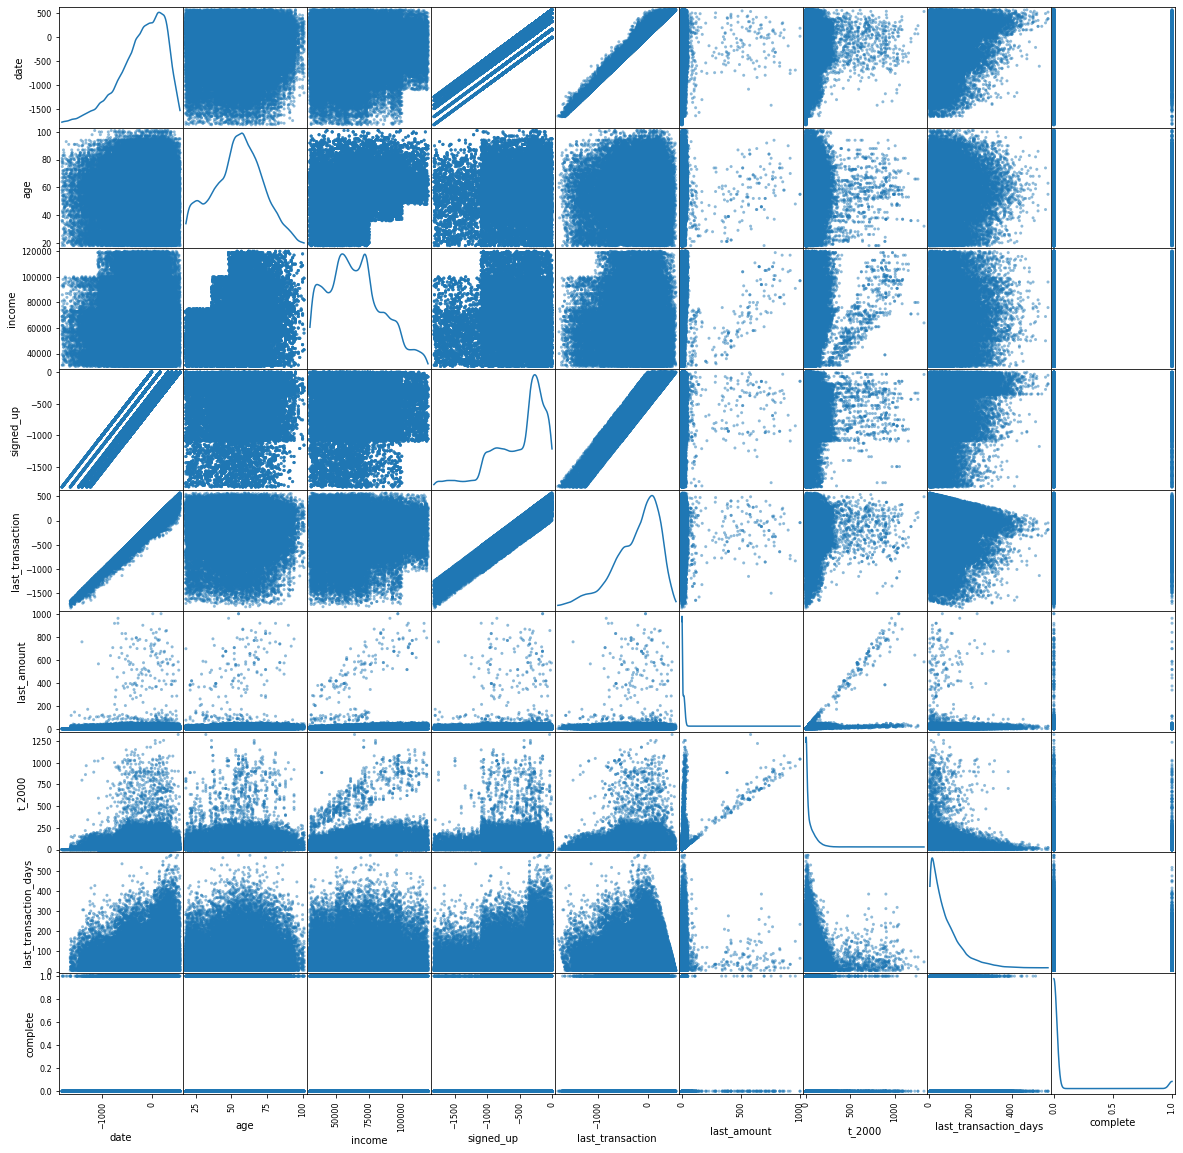

In [35]:
pd.plotting.scatter_matrix(df[['date', 'age', 'income', 'signed_up', 'last_transaction', 'last_amount', 't_2000', 'last_transaction_days', 'complete']], figsize=(20,20), diagonal='kde');

In [41]:
df.corr().complete.sort_values()

difficulty                  -0.049979
signed_up                   -0.048034
reward                      -0.035087
last_transaction            -0.030268
date                        -0.021050
web                         -0.020414
year                        -0.019951
bogo                        -0.015932
last_transaction_days       -0.014384
M                           -0.012919
duration                    -0.012185
month                       -0.002659
weekday                     -0.001847
day                         -0.000331
discount                     0.000652
O                            0.011628
informational                0.018722
social                       0.018807
t_7c                         0.019244
age                          0.022798
t_7                          0.023351
t_14c                        0.025426
t_14                         0.031014
t_28c                        0.032876
t_28                         0.033925
last_view_date               0.035419
hist_receive

In [47]:
df.corr().t_365.sort_values()

last_transaction_days       -0.164945
signed_up                   -0.109376
last_transaction            -0.030085
M                           -0.023594
duration                    -0.009352
web                         -0.006998
difficulty                  -0.006653
discount                    -0.006300
month                       -0.004215
weekday                     -0.002551
reward                      -0.000562
day                          0.001126
bogo                         0.002009
mobile                       0.003102
remaining to complete        0.004391
informational                0.005259
social                       0.006133
viewed_days_left             0.007606
O                            0.009140
viewed_in_valid              0.011669
date                         0.027948
year                         0.028163
last_view_date               0.028672
viewed_spend                 0.036430
received_spend               0.059990
age                          0.063671
offer_spend 

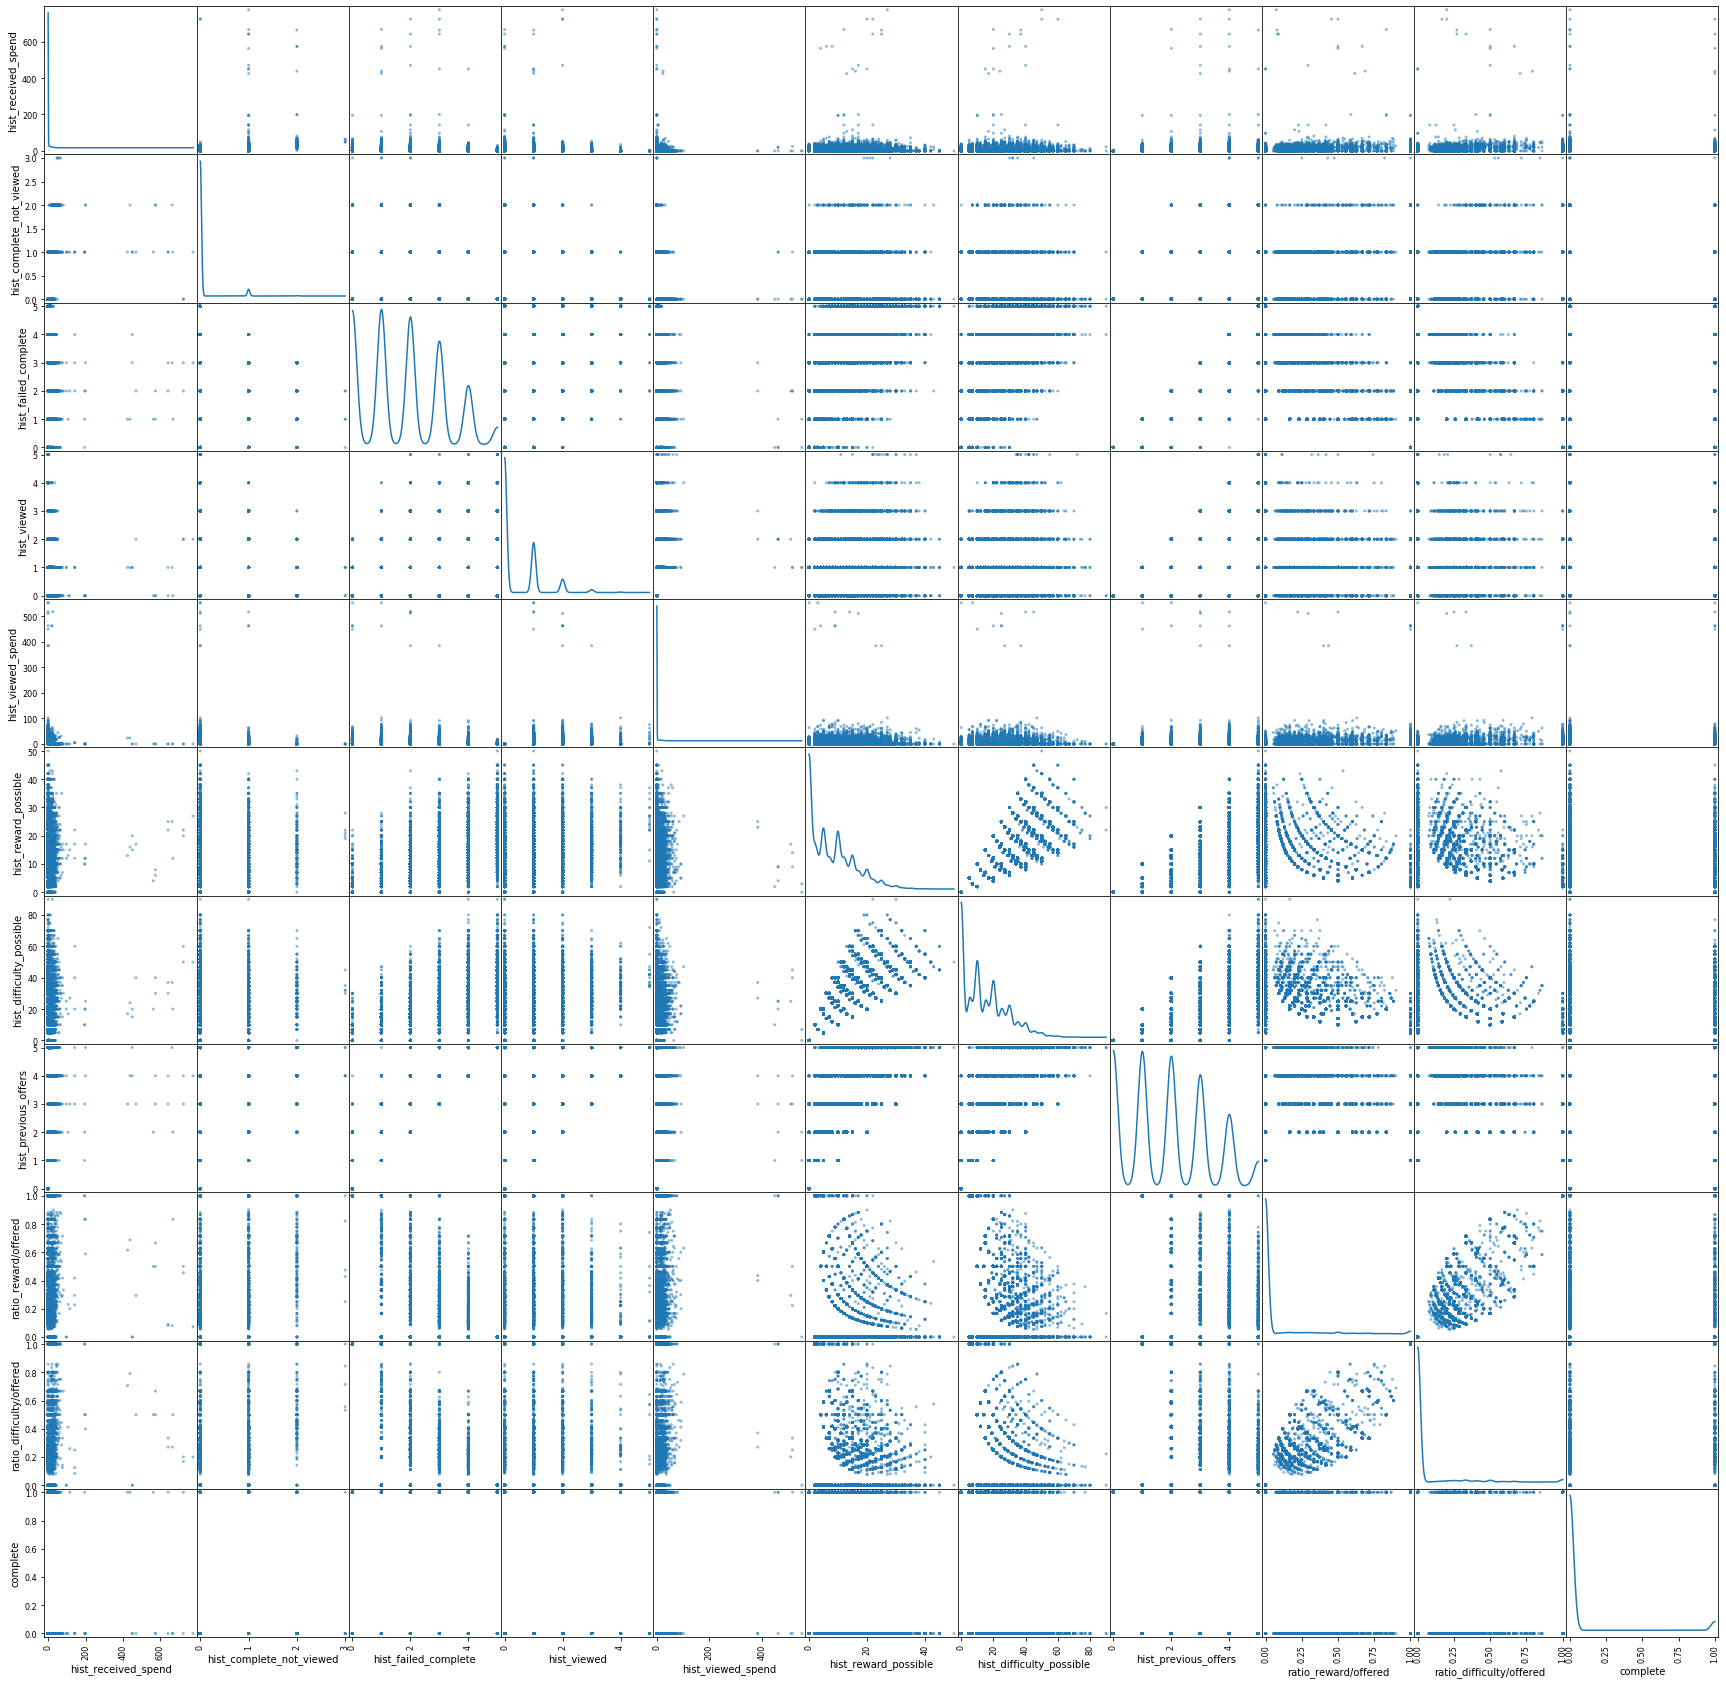

In [44]:
pd.plotting.scatter_matrix(df[['hist_received_spend', 'hist_complete_not_viewed', 'hist_failed_complete', 'hist_viewed', 'hist_viewed_spend', 'hist_reward_possible', 'hist_difficulty_possible', 'hist_previous_offers', 'ratio_reward/offered', 'ratio_difficulty/offered','complete']], figsize=(30,30), diagonal='kde');

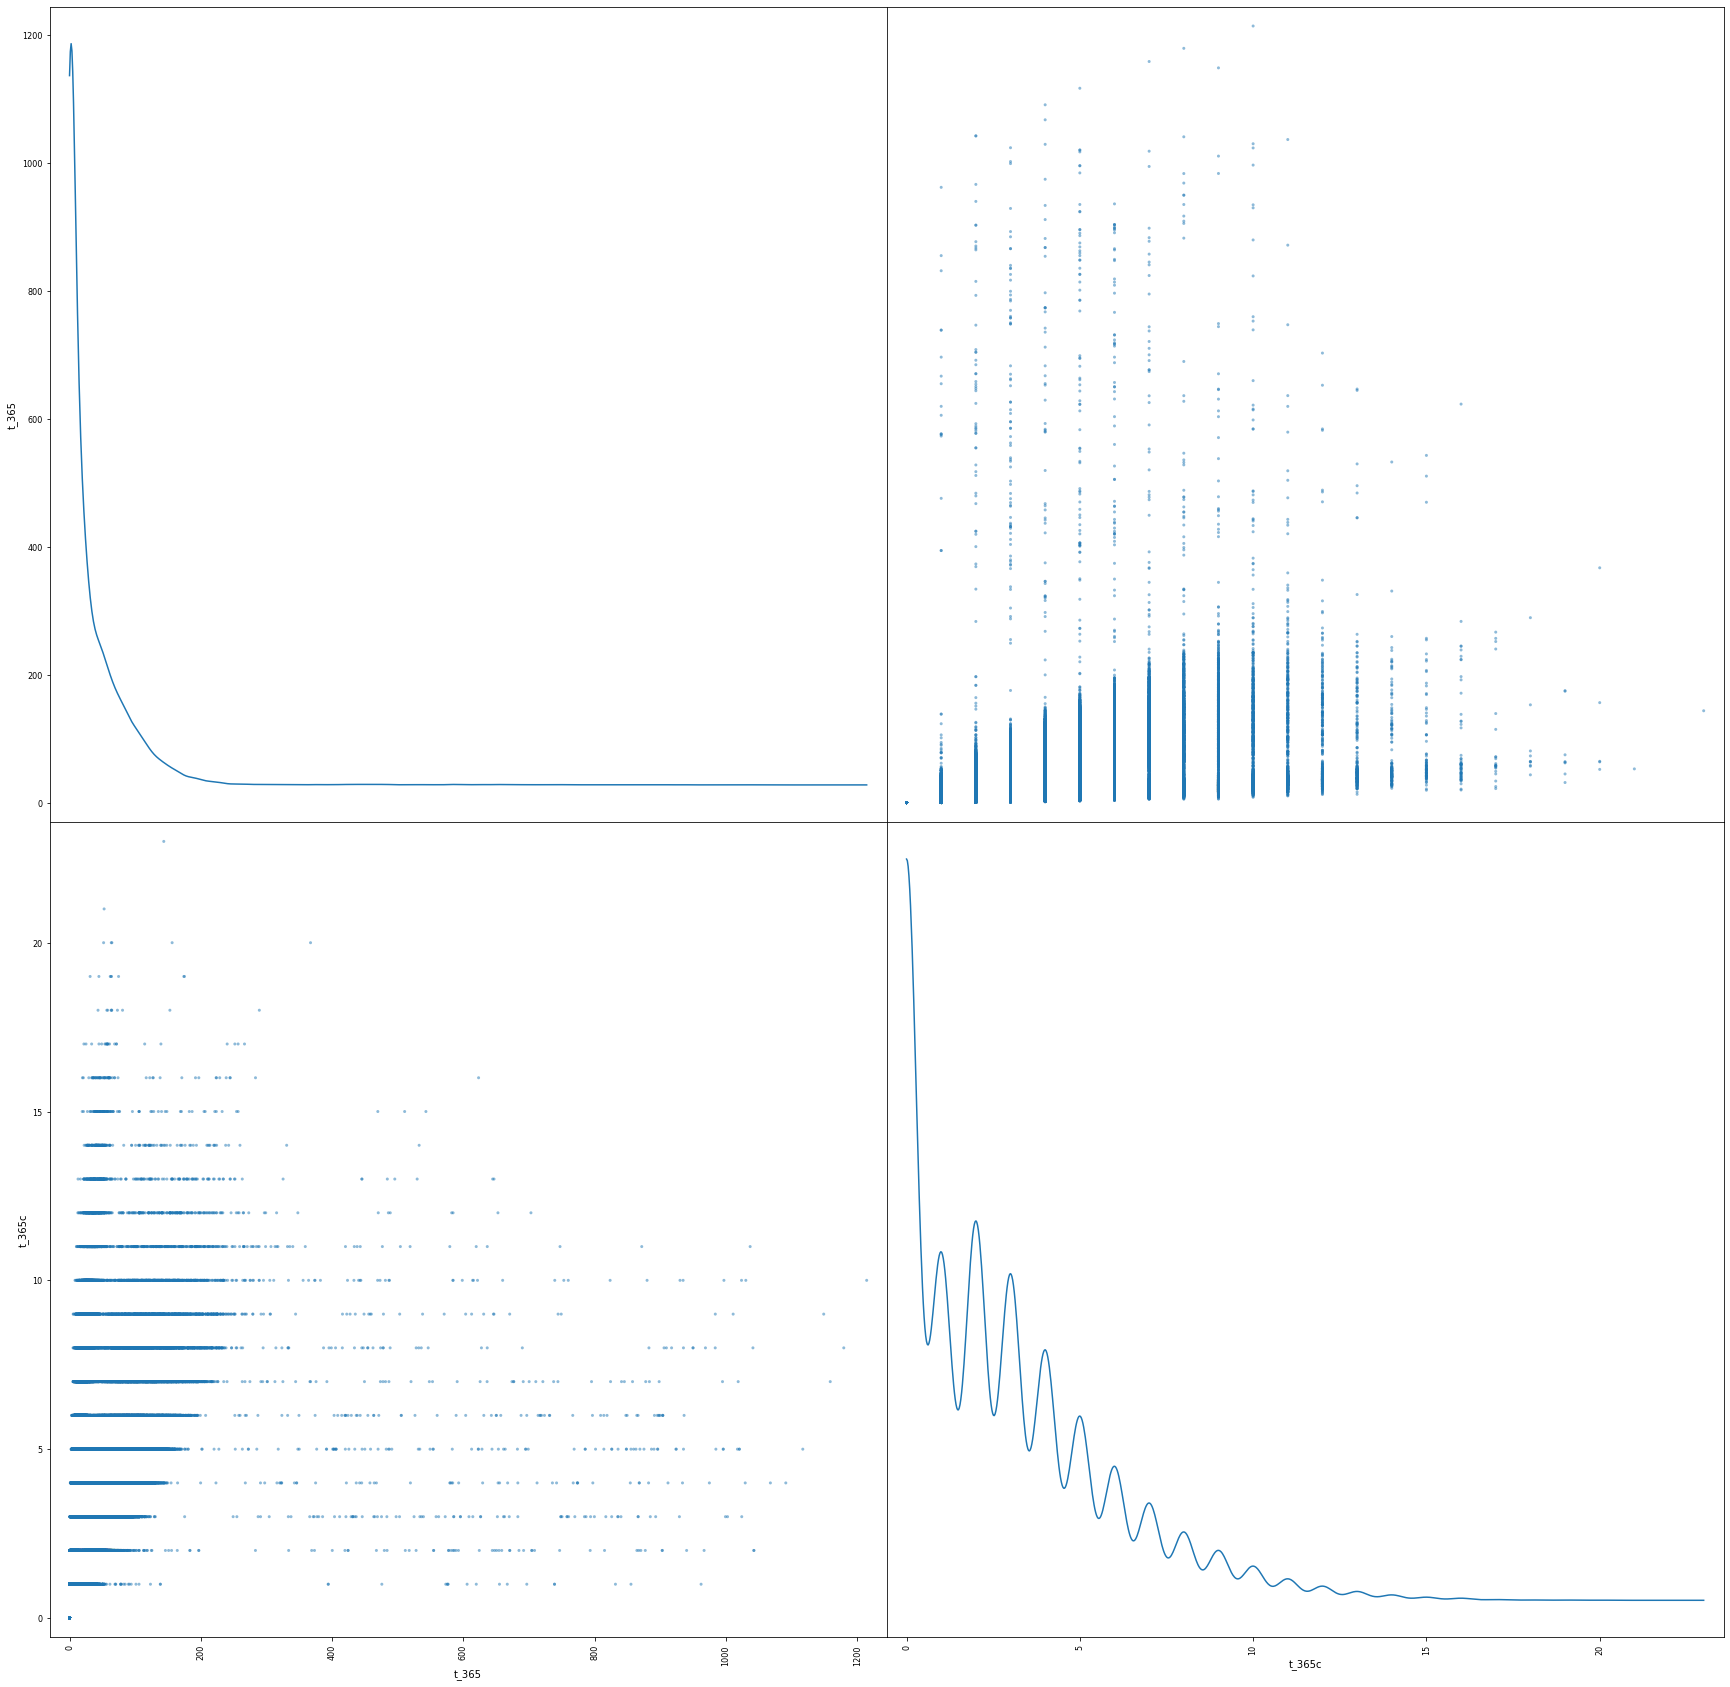

In [46]:
pd.plotting.scatter_matrix(df[['t_365', 't_365c']], figsize=(30,30), diagonal='kde');